# The Toxic Pesticides: Prediction of effect of Pesticides on  harvest

### By Ubong Ben

### INTRODUCTION

It has been well understood over the years that a farmer's job is a cyclic test of endurance and determination (Bergfjord, 2013; Filipiak et al., 2001). Once the seeds are sown, the farmer works days and nights to make sure that he cultivations lead up to a good harvest at the end of season. A good harvest is ensured by several factors such as availability of water, soil fertility, protecting crops from rodents, timely use of pesticides & other useful chemicals and nature. While a lot of these factors are difficult to control for, the amount and frequency of pesticides is something the farmer can control.

Pesticides are also special, because while they protect the crop with the right dosage (Johnsen et al., 2001). However if the additions is more thatn required, they may end up being disastrous to the entire harvest. A high level of pesticide can deem kill the crops altogether or, render them unsuitable for consumption (Ogut, 2019). 

In this project, we would design a machine learning model that would analyze the composition of pesticides and determing what would be the outcome in terms of harvest at the end of the farming season i.e. whether the crop would be healthy (alive), damaged by pesticides, or damaged by other reasons.

## Objective

To design a model that can predict if crops at harvest would be healthy, damaged by pesticides or destroyed through other reasons. 

In [3]:

#basic data science modules
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#for modelling
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

#machine learning tools
from sklearn import ensemble, preprocessing, tree, model_selection, feature_selection, pipeline, metrics
from imblearn import under_sampling, over_sampling, combine
from imblearn import pipeline as imb_pipeline
from imblearn import ensemble as imb_ensemble
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize, space, gbrt_minimize, dummy_minimize, forest_minimize
from functools import partial


ModuleNotFoundError: No module named 'imblearn'

## Import Data

In [1]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train = pd.read_csv('../dataset/train_yaOffsB.csv')
test = pd.read_csv('../dataset/test_pFkWwen.csv')

NameError: name 'os' is not defined

## Exploratory data analysis

In [6]:
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  int64  
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  int64  
 6   Number_Weeks_Used        79858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  int64  
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


In [7]:
#check number of unique rows in each column
train.nunique()

ID                         88858
Estimated_Insects_Count       71
Crop_Type                      2
Soil_Type                      2
Pesticide_Use_Category         3
Number_Doses_Week             20
Number_Weeks_Used             64
Number_Weeks_Quit             51
Season                         3
Crop_Damage                    3
dtype: int64

In [9]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

Seems that the dataset is relatively clean but gor the number of weeks used. We will fill that in with the median. 

In [ ]:
fill_values = train.median()
train = train.fillna(fill_values)
test = test.fillna(fill_values)

In [11]:
#check for skewness
train.skew()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11868\2818772921.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.skew()
C:\Users\DELL\AppData\Local\Temp\ipykernel_11868\2818772921.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test.skew()


Estimated_Insects_Count    0.847195
Crop_Type                  0.941381
Soil_Type                  0.180264
Pesticide_Use_Category     0.778521
Number_Doses_Week          0.929623
Number_Weeks_Used          0.235308
Number_Weeks_Quit          0.901358
Season                     0.139853
dtype: float64

In [12]:
test.skew()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11868\1515727625.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test.skew()


Estimated_Insects_Count    0.847195
Crop_Type                  0.941381
Soil_Type                  0.180264
Pesticide_Use_Category     0.778521
Number_Doses_Week          0.929623
Number_Weeks_Used          0.235308
Number_Weeks_Quit          0.901358
Season                     0.139853
dtype: float64

We will process our data to balance out the skewness..

In [13]:
#this function flattens out skewness
def preprocess(data):
    data['Estimated_Insects_Count'] = np.log1p(data['Estimated_Insects_Count'].values)
    data['Number_Weeks_Quit'] = np.log1p(data['Number_Weeks_Quit'].values)
    #data['Number_Weeks_Used'] = np.log1p(data['Number_Weeks_Used'].values)
    return data

train = preprocess(train)
test = preprocess(test)

In [18]:
cols=list(train.columns)
cols.remove('ID')

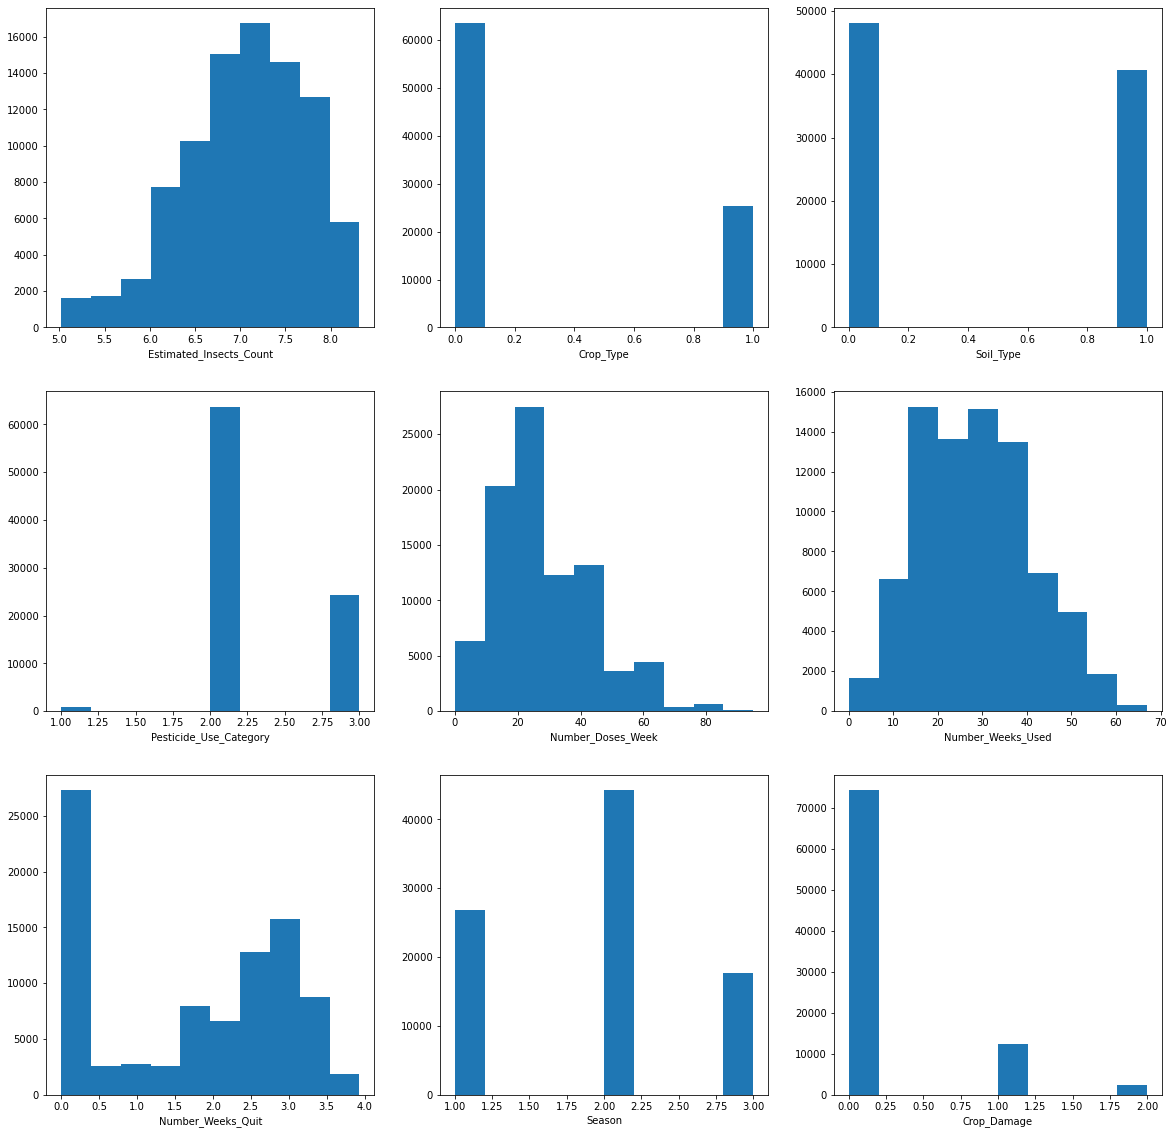

In [19]:
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
for col, axis in zip(cols, ax.flatten()):
    axis.hist(train[col])
    axis.set_xlabel(col)

Looks good. 

In [21]:
X = train.drop(['ID','Crop_Damage'], axis = 1)
y = train['Crop_Damage']


## Model Bulding

For our modelling process we will employ the Lightgbm  model which we will tune using skopt...

In [ ]:
def optimize_sk(params, param_names, X, y, scoring, estimator, cv = model_selection.StratifiedKFold(n_splits = 5)):
    '''params: list of param values
    param_names: param names
    x: training exogs
    y: training endogs
    return: negative metric after k fold validation'''

    params = dict(zip(param_names, params))

    # Initialize the model
    model = estimator(**params)

    kf = cv

    scores = []
    for train_index, test_index in kf.split(X, y):
        # Split Data
        X_train, y_train = np.array(X)[train_index, :], y[train_index]
        X_test, y_test = np.array(X)[test_index, :], y[test_index]

        # Fit model
        model.fit(X_train, y_train)

        # Evaluate model
        preds = model.predict(X_test)
        scores.append(scoring(y_test, preds))

    return -np.mean(scores)

# Scoring
def f1_score(y_true, y_pred):
    return metrics.f1_score(y_true, y_pred, average = 'macro')

def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

# Parameter Space
param_space = [
    space.Integer(500, 2500, name = 'n_estimators'),
    space.Integer(2, 10, name = 'max_depth'),
    space.Real(0, 1, name = 'feature_fraction'),
    space.Integer(2, 25, name = 'min_data_in_leaf'),
    space.Real(.001, .4, name = 'learning_rate')
]

# Param names
names = ['n_estimators', 'max_depth', 'feature_fraction', 'min_data_in_leaf', 'learning_rate']

cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category','Season']

# Define objective - reformat it in terms of what is required for skopt
objective_optimization = partial(optimize_sk, param_names = names, X = X, y = y, 
                                scoring = accuracy, estimator = partial(lgb.LGBMClassifier,
                                                                    cat_columns = cat_cols))

# Perform Optimization
#gbrt_minimize, dummy_minimize, forest_minimize
skopt_optimization = dummy_minimize(func = objective_optimization, 
                                dimensions = param_space, n_calls = 10,  
                                x0 = None, y0 = None, random_state = 10, 
                                verbose = 10)

In [ ]:
model = lgb.LGBMClassifier(**dict(zip(names, skopt_optimization.x))).fit(X, y)


We will now proceed to hand-tune our models. This may present better results....

In [2]:
## Create Hand-tuned Ensemble model
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category','Season']
model_cb = cb.CatBoostClassifier(cat_features = cat_cols, verbose = False)
model_lgb = lgb.LGBMClassifier(n_estimators = 1000, min_samples_in_leaf = 10, learning_rate = .02, 
                          feature_fraction = .8, max_depth = 8)
model_voting = ensemble.VotingClassifier([('catboost', model_cb), ('lightgbm', model_lgb)], 
                                         voting = 'soft').fit(X, y)


NameError: name 'cb' is not defined

In [ ]:
pred = pd.DataFrame()
pred['ID'] = test['ID'].values
pred['Crop_Damage'] = model_voting.predict(test.drop(['ID','Crop_Damage'], axis = 1)


Save as pickle file

In [ ]:
#saving model as pickle file
our_model = '../model/pest_model.pkl'
# Open the file to save as pkl file
model = open(our_model, 'wb')
pickle.dump(random_forest, model)
# Close the pickle instances
model.close()

### References

Bergfjord, O. J. 2013. “Farming and Risk Attitude.” Emirates Journal of Food and Agriculture. https://doi.org/10.9755/ejfa.v25i7.13584.

Filipiak, B., J. Heinrich, T. Schäfer, J. Ring, and H. E. Wichmann. 2001. “Farming, Rural Lifestyle and Atopy in Adults from Southern Germany - Results from the MONICA/KORA Study Augsburg.” Clinical and Experimental Allergy. https://doi.org/10.1046/j.1365-2222.2001.01246.x.

Johnsen, Kaare, Carsten S. Jacobsen, Vigdis Torsvik, and Jan Sørensen. 2001. “Pesticide Effects on Bacterial Diversity in Agricultural Soils - A Review.” Biology and Fertility of Soils. https://doi.org/10.1007/s003740100351.

Ogut, Serdal. 2019. “Genotoxic Effects of Pesticides.” Journal of Environmental Protection and Ecology.

